# VADs testings

In [3]:
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from scipy import signal
import os

In [ ]:
import os 
import torchaudio

In [4]:
import torch
import torchaudio
import librosa
import numpy as np
import webrtcvad
from scipy.signal import find_peaks

# Опционально: Проверяем доступность SpeechBrain и OpenVINO
try:
    from speechbrain.pretrained import VAD as SpeechBrainVAD
except ImportError:
    print('cant import SpeechBrainVAD')
    SpeechBrainVAD = None

try:
    from openvino.runtime import Core
except ImportError:
    print('cant import openvino')
    Core = None


c:\Users\Bogdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Bogdan\AppData\Local\Programs\Python\Python311\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_18204\990377766.py:10: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD as SpeechBr

# audion prep

In [72]:
audios = [] # (waveform, mask, age)

In [73]:
def plot_waveform_with_mask(waveform, mask, sample_rate=16000):
    plt.figure(figsize=(12, 4))

    # Рисуем волновую форму
    time = range(len(waveform))
    plt.plot(time, waveform, label='Waveform', color='blue')

    # Наносим маску
    plt.plot(time, mask, label='Mask', color='red', alpha=0.5)

    # Оформление графика
    plt.title("Waveform with Mask")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

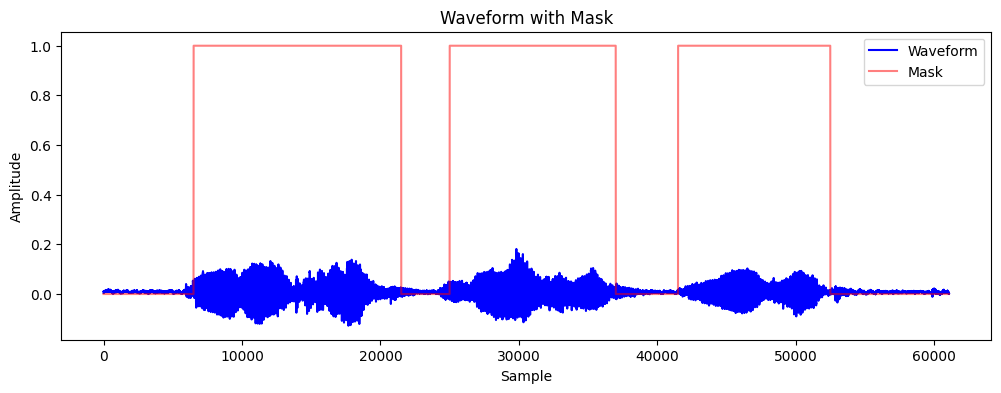

In [74]:
path = os.path.join("Vino2.wav") # взрослый
waveform, sample_rate = torchaudio.load(path)

waveform
mask = [0]*6500 + [1]*15000 + [0]*3500 + [1]*12000 + [0]*4500 + [1]*11000
mask += [0]*(len(waveform[0]) - len(mask))

plot_waveform_with_mask(waveform.view(-1), mask)

audios.append((waveform, mask, 'adult'))

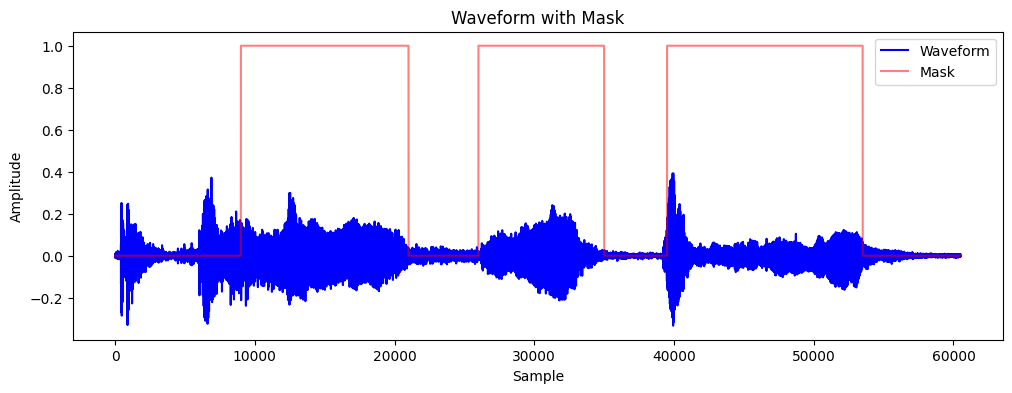

In [75]:
path = os.path.join("vinograd2.wav") # детский
waveform, sample_rate = torchaudio.load(path)

waveform
mask = [0]*9000 + [1]*12000 + [0]*5000 + [1]*9000 + [0]*4500 + [1]*14000
mask += [0]*(len(waveform[0]) - len(mask))

plot_waveform_with_mask(waveform.view(-1), mask)

audios.append((waveform, mask, 'child'))

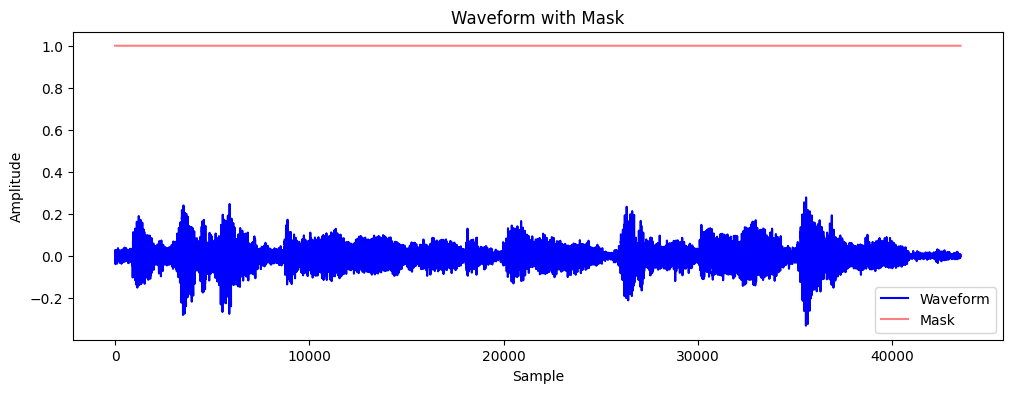

In [76]:


path = os.path.join(r"E:\mai\Speech\speech_enhancement\audios\ребенок_4_5.wav") # детский средний
waveform, sample_rate = torchaudio.load(path)

waveform
mask = []
mask += [1]*(len(waveform[0]) - len(mask))
plot_waveform_with_mask(waveform.view(-1), mask)

audios.append((waveform, mask, 'teen'))

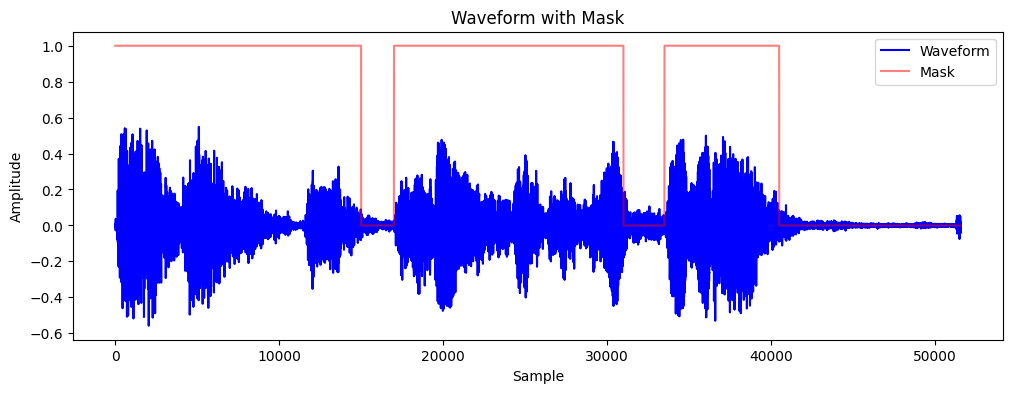

In [77]:


path = os.path.join(r"E:\mai\Speech\speech_enhancement\audios\учитель_6.wav")
waveform, sample_rate = torchaudio.load(path)

waveform
mask = [1]*15000 + [0]*2000 + [1]*14000 + [0]*2500+ [1]*7000 
mask += [0]*(len(waveform[0]) - len(mask))
plot_waveform_with_mask(waveform.view(-1), mask)

audios.append((waveform, mask, 'adult'))

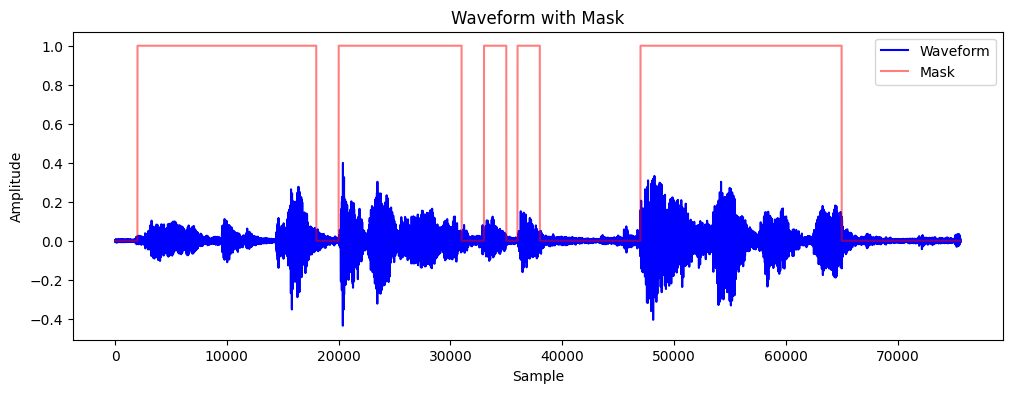

In [78]:


path = os.path.join(r"E:\mai\Speech\speech_enhancement\audios\ребенок_4.wav") # средний 2
waveform, sample_rate = torchaudio.load(path)

waveform
mask = [0]*2000 + [1]*16000 + [0]*2000 + [1]*11000 + [0]*2000 + [1]*2000 + [0]*1000 + [1]*2000 + [0]*9000 + [1]*18000
mask += [0]*(len(waveform[0]) - len(mask))
plot_waveform_with_mask(waveform.view(-1), mask)

audios.append((waveform, mask, 'teen'))

# other

In [81]:

class VADInterface:
    def __init__(self, model_type="webrtc", aggressiveness=3):
        self.model_type = model_type

        if model_type == "webrtc":
            self.vad = webrtcvad.Vad(aggressiveness)
        elif model_type == "silero":
            self.model, _ = torch.hub.load('snakers4/silero-vad', 'silero_vad')
        elif model_type == "torchaudio":
            pass  # Используем torchaudio.functional.vad напрямую
        elif model_type == "librosa":
            pass  # Не требуется загрузка модели
        elif model_type == "speechbrain" and SpeechBrainVAD:
            self.model = SpeechBrainVAD.from_hparams(
                source="speechbrain/vad-crdnn-libriparty", savedir="tmp"
            )
        elif model_type == "openvino" and Core:
            self.core = Core()
            self.model = self.core.read_model("vad_model.xml")  # Укажите путь к вашей модели
            self.compiled_model = self.core.compile_model(self.model, "CPU")
        else:
            raise ValueError(f"Unsupported or unavailable VAD type: {model_type}")

    def apply_vad(self, waveform, sample_rate):
        if self.model_type == "webrtc":
            return self._webrtc_vad(waveform, sample_rate)
        elif self.model_type == "silero":
            return self._silero_vad(waveform, sample_rate)
        elif self.model_type == "torchaudio":
            return torchaudio.functional.vad(waveform, sample_rate, search_time=3)
        elif self.model_type == "librosa":
            return self._librosa_vad(waveform, sample_rate)
        elif self.model_type == "speechbrain":
            return self._speechbrain_vad("audio.wav")  # SpeechBrain работает с файлами
        elif self.model_type == "openvino":
            return self._openvino_vad(waveform)

    def _webrtc_vad(self, waveform, sample_rate):
        frame_size = int(sample_rate * 0.02)  # 20ms frames
        return torch.cat([
            waveform[:, i:i + frame_size]
            for i in range(0, waveform.shape[1], frame_size)
            if self.vad.is_speech(waveform[:, i:i + frame_size].numpy().tobytes(), sample_rate)
        ], dim=1)

    def _silero_vad(self, waveform, sample_rate):
        window = 512

        waveform=waveform[0]
        ub = (len(waveform) // window)*window
        full = []
        for i in range(0, len(waveform[:ub]), window):
            res = self.model(waveform[i:i+window], 16000)
            full += [res.detach().numpy()]*window
        
        speech_probs = np.array(full)[:,0, 0]
        
        mask = speech_probs > 0.5
        return mask
        return waveform[:ub][mask]

    def _librosa_vad(self, waveform, sample_rate):
        '''"""Простая реализация VAD с использованием RMS энергии."""
        energy = librosa.feature.rms(y=waveform.numpy().flatten())
        threshold = np.mean(energy) * 0.5  # Эвристический порог
        mask = energy.flatten() > threshold
        print(mask.shape)
        print(energy.shape)
        peaks, _ = find_peaks(mask)  # Находим интервалы активной речи
        return waveform[:, peaks]'''
        frame_length = 2048 #60504
        hop_length = 512
        # Разделение на фреймы
        def frame_signal(waveform, frame_length, hop_length):
            return waveform.unfold(1, frame_length, hop_length)

        framed_signal = frame_signal(waveform, frame_length, hop_length)
        energies = torch.sum(framed_signal**2, dim=2)

        # Определение активных участков
        energy_threshold = np.median(energies) * 1.3#0.02
        vad_mask = energies > energy_threshold
        return np.repeat(vad_mask, hop_length)
        return vad_mask

    '''def _speechbrain_vad(self, filepath):
        """VAD с использованием SpeechBrain."""
        boundaries = self.model.get_speech_segments(filepath)
        print(f"Speech segments: {boundaries}")
        return boundaries

    def _openvino_vad(self, waveform):
        """VAD с использованием OpenVINO."""
        inputs = {self.model.inputs[0]: waveform.numpy()}
        result = self.compiled_model(inputs)[self.model.outputs[0]]
        mask = result.squeeze() > 0.5  # Бинаризуем результаты
        return waveform[:, mask]'''



def plot_waveforms(original, processed_list, sample_rate, labels):
    """Визуализирует оригинальное и обработанное аудио."""
    plt.figure(figsize=(12, 6))
    time = np.linspace(0, len(original[0]) / sample_rate, len(original[0]))

    plt.plot(time, original[0].numpy(), label="Original", alpha=0.6)
    for processed, label in zip(processed_list, labels):
        plt.plot(time[:len(processed[0])], processed[0].numpy(), label=label, alpha=0.6)

    plt.legend()
    plt.title("VAD Comparison")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()





In [82]:
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from scipy import signal

def load_audio(filepath):
    """Load audio using torchaudio."""
    waveform, sample_rate = torchaudio.load(filepath)
    return waveform, sample_rate

def add_white_noise(waveform, noise_factor=0.005):
    """Add white noise to the waveform."""
    noise = np.random.normal(0, noise_factor, waveform.shape)
    return waveform + torch.from_numpy(noise).float()

def add_pink_noise(waveform, noise_factor=0.005):
    """Add pink noise to the waveform."""
    n_samples = waveform.shape[1]
    uneven = n_samples % 2
    X = np.random.randn(n_samples // 2 + 1 + uneven) + 1j * np.random.randn(n_samples // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)  # 1/f frequency scaling
    y = (np.fft.irfft(X / S)).real
    pink_noise = np.tile(y[:n_samples], (waveform.shape[0], 1))
    return waveform + noise_factor * torch.from_numpy(pink_noise).float()

def add_brown_noise(waveform, noise_factor=0.005):
    """Add brown noise to the waveform."""
    n = np.cumsum(np.random.randn(waveform.shape[1]))  # Brownian motion
    brown_noise = n / np.max(np.abs(n))  # Normalize
    return waveform + noise_factor * torch.from_numpy(brown_noise).float()

def add_gaussian_noise(waveform, noise_factor=0.005):
    """Add Gaussian noise to the waveform."""
    noise = np.random.normal(0, noise_factor, waveform.shape)
    return waveform + torch.from_numpy(noise).float()

def plot_waveforms(original, noisy, sample_rate, title):
    """Plot original and noisy audio signals."""
    plt.figure(figsize=(12, 4))
    time = np.linspace(0, len(original[0]) / sample_rate, len(original[0]))

    plt.plot(time, original[0].numpy(), label="Original", alpha=0.6)
    plt.plot(time, noisy[0].numpy(), label="Noisy", alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def test_noise():
    # Load an audio file
    original, sample_rate = load_audio("original.wav")

    # Add various types of noise
    noisy_white = add_white_noise(original, noise_factor=0.01)
    noisy_pink = add_pink_noise(original, noise_factor=0.01)
    noisy_brown = add_brown_noise(original, noise_factor=0.01)
    noisy_gaussian = add_gaussian_noise(original, noise_factor=0.01)

    # Plot the results for comparison
    plot_waveforms(original, noisy_white, sample_rate, "White Noise")
    plot_waveforms(original, noisy_pink, sample_rate, "Pink Noise")
    plot_waveforms(original, noisy_brown, sample_rate, "Brown Noise")
    plot_waveforms(original, noisy_gaussian, sample_rate, "Gaussian Noise")


In [99]:
import torch

def iou(pred: torch.Tensor, target: torch.Tensor) -> float:
    """
    Вычисление метрики Intersection over Union (IoU) для одномерных тензоров.
    
    :param pred: предсказания, одномерный тензор
    :param target: целевые значения, одномерный тензор
    :return: значение IoU
    """
    pred = torch.tensor(pred)
    target = torch.tensor(target)
    # Приведение предсказаний к бинарному виду (если нужно)
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    # Вычисление пересечения и объединения
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection

    # Избегаем деления на 0
    iou_value = intersection / union if union != 0 else torch.tensor(0.0)

    return iou_value.item()


def dice(pred: torch.Tensor, target: torch.Tensor) -> float:
    """
    Вычисление Dice коэффициента для одномерных тензоров.
    
    :param pred: предсказания, одномерный тензор
    :param target: целевые значения, одномерный тензор
    :return: значение Dice
    """
    pred = torch.tensor(pred)
    target = torch.tensor(target)
    # Приведение предсказаний к бинарному виду (если нужно)
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    # Вычисление пересечения
    intersection = torch.sum(pred * target)
    # Вычисление Dice коэффициента
    dice_value = (2 * intersection) / (torch.sum(pred) + torch.sum(target))

    return dice_value.item()



In [84]:
def apply_webrtc(waveform, sample_rate=16000):
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        sample_rate = 16000

    # Преобразуем в моно (если аудиофайл стерео)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)

    # Преобразуем тензор в PCM-байты
    audio_bytes = (waveform.numpy().flatten() * 32767).astype("int16").tobytes()

    vad = webrtcvad.Vad(2)  # 2 – средняя агрессивность

    frame_duration = 30 
    frame_size = int(sample_rate * frame_duration / 1000) * 2
    num_frames = len(audio_bytes) // frame_size

    speech_mask = np.zeros(num_frames, dtype=np.int32)

    for i in range(num_frames):
        frame = audio_bytes[i * frame_size: (i + 1) * frame_size]
        if vad.is_speech(frame, sample_rate):
            speech_mask[i] = 1

    return torch.from_numpy(speech_mask).repeat_interleave(int(sample_rate * frame_duration / 1000))


In [85]:
vad_silero = VADInterface(model_type="silero")
vad_librosa = VADInterface(model_type="librosa")

Using cache found in C:\Users\Bogdan/.cache\torch\hub\snakers4_silero-vad_master


In [86]:
processed_list = []
sample_rate = 16000

for waveform, mask, age in audios:
    processed_list.append(('silero', vad_silero.apply_vad(waveform, sample_rate), mask, age))
    processed_list.append(('webrtc', apply_webrtc(waveform, sample_rate), mask, age))
    processed_list.append(('librosa', vad_librosa.apply_vad(waveform, sample_rate), mask, age))

In [103]:
results = []

for vad_name, pred_mask, gt_mask, age in processed_list:
    iou_value = iou(pred_mask, gt_mask[:len(pred_mask)])
    dice_value = dice(pred_mask, gt_mask[:len(pred_mask)])
    results.append((vad_name, age, iou_value, dice_value))

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_18204\4236538737.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred)
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_18204\4236538737.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred)


In [104]:
import pandas as pd
df = pd.DataFrame(results, columns=['vad_name', 'age', 'iou_value', 'dice_value'])


In [105]:
df

,vad_name,age,iou_value,dice_value
0,silero,adult,0.745103,0.853936
1,webrtc,adult,0.822939,0.902871
2,librosa,adult,0.684847,0.812949
3,silero,child,0.663290,0.797564
4,webrtc,child,0.760105,0.863704
5,librosa,child,0.478443,0.647225
6,silero,teen,0.988235,0.994083
7,webrtc,teen,0.966667,0.983051
8,librosa,teen,0.304878,0.467290
9,silero,adult,0.799006,0.888275


In [106]:
df.groupby(["vad_name", "age"])[["iou_value", "dice_value"]].mean().reset_index()

,vad_name,age,iou_value,dice_value
0,librosa,adult,0.619118,0.762721
1,librosa,child,0.478443,0.647225
2,librosa,teen,0.413703,0.576843
3,silero,adult,0.772054,0.871105
4,silero,child,0.663290,0.797564
5,silero,teen,0.882926,0.934491
6,webrtc,adult,0.832818,0.908753
7,webrtc,child,0.760105,0.863704
8,webrtc,teen,0.862633,0.922891


In [107]:
df.pivot_table(
    index="vad_name", columns="age", values="dice_value", aggfunc="mean"
)

age,adult,child,teen
vad_name,,,
librosa,0.762721,0.647225,0.576843
silero,0.871105,0.797564,0.934491
webrtc,0.908753,0.863704,0.922891


In [108]:
df.pivot_table(
    index="vad_name", columns="age", values="iou_value", aggfunc="mean"
)

age,adult,child,teen
vad_name,,,
librosa,0.619118,0.478443,0.413703
silero,0.772054,0.663290,0.882926
webrtc,0.832818,0.760105,0.862633
